In [51]:
#!pip install tensorflow

In [52]:
import tensorflow as tf

In [53]:
import cv2
import warnings
warnings.filterwarnings(action='ignore')

In [54]:
import numpy as np
import pandas as pd
import os

In [55]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [56]:
import os

base_path = "data"
train_dir = os.path.join(base_path, 'train/train')
test_dir = os.path.join(base_path, 'test/test')

img_height, img_width = 224, 224
batch_size = 32


In [57]:
from tensorflow.keras.optimizers import Adam

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: Real or Deepfake
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)  # Normalizing pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'  # For binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 479 images belonging to 2 classes.
Found 499 images belonging to 2 classes.


In [60]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss' , patience=3 , restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight

# Get class indices (e.g., {'fake': 0, 'real': 1})
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

# Get class weights
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weight))
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.5839 - loss: 0.9429 - val_accuracy: 0.2208 - val_loss: 1.1048
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.6250 - loss: 0.7316 - val_accuracy: 0.2208 - val_loss: 1.1400
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 125s 9s/step - accuracy: 0.6734 - loss: 0.6182 - val_accuracy: 0.3708 - val_loss: 0.8315
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7812 - loss: 0.5219 - val_accuracy: 0.3604 - val_loss: 0.8489
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 126s 9s/step - accuracy: 0.6801 - loss: 0.6021 - val_accuracy: 0.2625 - val_loss: 1.1297
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.6875 - loss: 0.5610 - val_accuracy: 0.2438 - val_loss: 1.2183
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 127s 9s/step - accuracy: 0.6823 - loss: 0.6058 - val_accuracy: 0.2250 - val_loss: 1.3302
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5625 - loss: 0.8774 - val_accuracy: 0.2229 - val_l

In [61]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.3006 - loss: 0.7582
Test Loss: 0.758212685585022
Test Accuracy: 0.30060121417045593


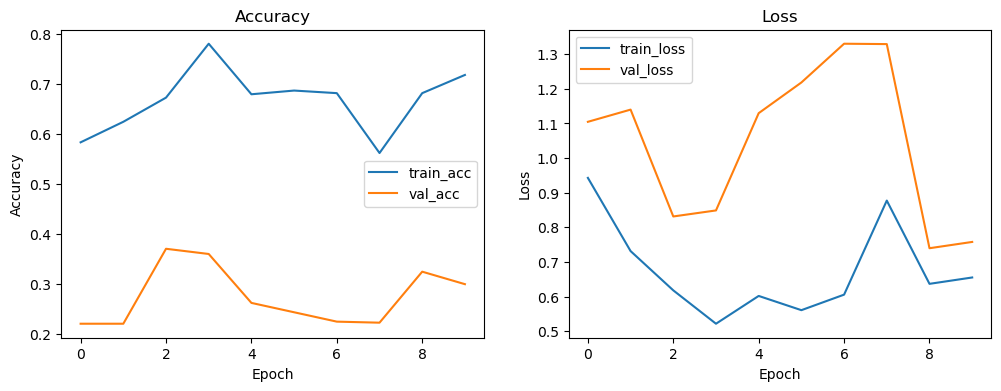

In [62]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [63]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        print(f"Prediction: Real ({prediction:.2f})")
    else:
        print(f"Prediction: Fake ({1 - prediction:.2f})")


predict_image("ai image.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Prediction: Real (0.59)
